# Segmenting and Clustering Neighbourhoods in Toronto, Canada
## Part 1 - Building the DataFrame

Before we start, let's get all the required libraries imported.

In [3]:
import pandas as pd 

import numpy as np

import matplotlib as plt
import matplotlib.cm as cm # colour maps
import matplotlib.colors as colors # colour conversion

from sklearn.cluster import KMeans # for performing our k-means clustering

import folium # for mapping

import requests # an HTTP library that we'll use for accessing FourSquare

Our first job is to pull together the location data for the neighbourhoods.

We can use the table on Wikipedia which contains a list of postcodes of boroughs in Canada, which we can import very easily using pandas. It returns a list of DataFrames, each one relating to a table in the webpage. Having inspected the page, we can see that the one we require is the first table.

In [4]:
tables = pd.read_html( "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" )
postcodes_df = tables[ 0 ]
postcodes_df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


We are only interested in those postal codes with a borough assigned.

In [5]:
postcodes_df = postcodes_df[ postcodes_df["Borough"] != "Not assigned"]
postcodes_df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Do we have any empty neighbourhoods?

In [6]:
len(postcodes_df[ postcodes_df[ "Neighborhood" ].isnull() ])

0

No, we don't.

Let's have a look at the shape of our DataFrame.

In [7]:
postcodes_df.shape

(103, 3)

So postcode and borough data for 103 neighbourhoods in Canada.

## Part 2 - Adding location data
Given the lack of reliability of the Geocoder package, I'm using the CSV provided.

In [8]:
location_df = pd.read_csv( "https://cocl.us/Geospatial_data" )
location_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Let's merge the two DataFrames using the Postal Code field in each.

In [9]:
postcodes_with_location_df = pd.merge( left = postcodes_df , right = location_df , how = "left" , on="Postal Code" )
postcodes_with_location_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Part 3 - Explore and cluster the neighbourhoods

Let's look for only those boroughs that contain the word Toronto

In [10]:
toronto_df = postcodes_with_location_df[ postcodes_with_location_df[ "Borough" ].str.contains( "Toronto") ]
toronto_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


Let's get the average latitude and longitude across the entire DataFrame so that we can use that as the centre of a map of Toronto.

In [11]:
location = toronto_df.mean()
toronto_map = folium.Map( location=[location.loc["Latitude"],location.loc["Longitude"]] , zoom_start = 12 )

Let's add the borough markers to the map and take a look.

In [12]:
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  

toronto_map

Next, we'll use the FourSquare API to explore the neighbourhoods in Toronto using the same approach as that used in the ungraded exercise.

In [13]:
CLIENT_ID = 'AZKXH5PM02UGZGWNHWEPHVWEKAZ5RWSNRYBZNSSJT3EOBC2N' # your Foursquare ID
CLIENT_SECRET = 'XGWLP3PRPFSBGN0W534NRHRNNYT4IN5UT5QRJMBD4TAIOML5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Create a function that collects information from FourSquare for all venues within 500 metres of the centre of each neighbourhood.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [70]:
LIMIT = 100
toronto_venues = getNearbyVenues( 
    names=toronto_df["Neighborhood"] , 
    latitudes=toronto_df["Latitude"] , 
    longitudes=toronto_df["Longitude"]
)
toronto_venues

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.654260,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
...,...,...,...,...,...,...,...
1609,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Toronto Yoga Mamas,43.664824,-79.324335,Yoga Studio
1610,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Olliffe On Queen,43.664503,-79.324768,Butcher
1611,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,TTC Stop #03049,43.664470,-79.325145,Light Rail Station
1612,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,ONE Academy,43.662253,-79.326911,Gym / Fitness Center


In [72]:
print( "There are {} unique categories of venue.".format( len( toronto_venues["Venue Category" ].unique() ) ) )

There are 236 unique categories of venue.


One of the venue categories is called "Neighborhood"; we will change this to "Neighborhood Venue" to avoid a conflict later on.

In [73]:
toronto_venues["Venue Category" ] = toronto_venues[ "Venue Category" ].str.replace( "Neighborhood" ,  "Neighborhood Venue" , regex=False )

Next, we need to create a column for each category (onehot encoding) then perform the clustering using the scikit library.

In [75]:
toronto_onehot = pd.concat(
    [ 
        toronto_venues["Neighborhood"],
        pd.get_dummies( toronto_venues[["Venue Category"]] , prefix="",prefix_sep="")
    ], 
    axis=1 )

print( toronto_onehot.shape )
toronto_onehot.head()

(1614, 237)


,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
toronto_grouped = toronto_onehot.groupby( "Neighborhood" ).mean().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.018519,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.0,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.052632
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0625,0.0625,0.125,0.1875,0.125,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,Central Bay Street,0.0,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.015873,0.0,0.0,0.015873,0.0,0.0,0.0,0.015873


Let's have a look at the types of venue in each of the neighbourhoods and see which categories are most popular in each.

In [77]:
def return_most_common_venues( row , num_top_venues ):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

The following will create a dataframe that we can review to help understand which categories of venue are the most popular.

In [78]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Bakery,Beer Bar,Seafood Restaurant,Cheese Shop,Café,Jazz Club,Clothing Store
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Pet Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Garden,Skate Park,Burrito Place,Farmers Market,Spa,Fast Food Restaurant,Butcher,Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Bar,Plane,Rental Car Location,Sculpture Garden,Boat or Ferry,Boutique
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Bubble Tea Shop,Salad Place,Burger Joint,Japanese Restaurant,Department Store,Falafel Restaurant


Let's run the k-means to cluster the neighbourhoods into five clusters.

In [79]:
number_of_clusters = 5

toronto_clustered = toronto_grouped.drop( "Neighborhood" , 1 )

kmeans = KMeans( n_clusters=number_of_clusters , random_state=0 ).fit( toronto_clustered )

kmeans.labels_.shape

(39,)

Now we can add the clustering labels to the neighbourhood popularity DataFrame that we created above.

In [80]:
# add the clustering labels that we created above

neighborhoods_venues_sorted.insert( 0 , 'Cluster Label' , kmeans.labels_ )
neighborhoods_venues_sorted

,Cluster Label,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Bakery,Beer Bar,Seafood Restaurant,Cheese Shop,Café,Jazz Club,Clothing Store
1,1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Pet Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue
2,1,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Garden,Skate Park,Burrito Place,Farmers Market,Spa,Fast Food Restaurant,Butcher,Restaurant
3,1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Bar,Plane,Rental Car Location,Sculpture Garden,Boat or Ferry,Boutique
4,1,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Bubble Tea Shop,Salad Place,Burger Joint,Japanese Restaurant,Department Store,Falafel Restaurant
5,1,Christie,Grocery Store,Café,Park,Diner,Baby Store,Candy Store,Athletics & Sports,Italian Restaurant,Restaurant,Coffee Shop
6,1,Church and Wellesley,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Café,Pub,Men's Store,Mediterranean Restaurant,Hotel
7,1,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Café,Hotel,American Restaurant,Gym,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Deli / Bodega
8,1,Davisville,Pizza Place,Sandwich Place,Dessert Shop,Coffee Shop,Thai Restaurant,Café,Italian Restaurant,Sushi Restaurant,Gym,Park
9,1,Davisville North,Gym / Fitness Center,Hotel,Pizza Place,Department Store,Sandwich Place,Breakfast Spot,Food & Drink Shop,Park,General Entertainment,Ethiopian Restaurant


We need to join the original data that contains the location data with the labelled clusters.

In [81]:
neighborhoods_venues_sorted[ "Cluster Label" ] = kmeans.labels_

toronto_merged = toronto_df
toronto_merged = toronto_merged.join( neighborhoods_venues_sorted.set_index( "Neighborhood" ) , on="Neighborhood" )

Let's see how that looks...

In [82]:
map_clusters = folium.Map( location=[ location.loc[ "Latitude" ] , location.loc[ "Longitude" ] ] , zoom_start = 12 )

x = np.arange(number_of_clusters)
ys = [i + x + (i*x)**2 for i in range(number_of_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], 
                                  toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The five clusters illustrate a fairly pronounced difference between those neighbourhoods near the lake compared with those inland with all those near the lake being in one cluster. Let's have a look at how those clusters are distrubuted.

In [83]:
toronto_merged[ "Cluster Label" ].value_counts()

1    34
3     2
4     1
2     1
0     1
Name: Cluster Label, dtype: int64

So the vast majority of neighbourhoods, 34, are in one cluster. Either all the neighbourhoods are pretty similar or we should up the number of clusters.

Let's see how increasing clusters affects the error level.

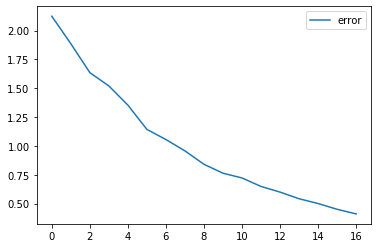

In [85]:
cluster_results = pd.DataFrame( columns = [ "error" ] )
for number_of_clusters in range(3,20):
    kmeans = KMeans( n_clusters = number_of_clusters , random_state=0 ).fit( toronto_clustered )
    cluster_results = cluster_results.append( { "error" : kmeans.inertia_ } , ignore_index = True )
    
cluster_results.plot( y="error" )

There's no obvious elbow here so this particular k-means algorithm hasn't been able to find good clusters. We're unable to visualise the data as there are 235 dimensions!

Let's have a look at 10 clusters to see whether there's anything that we can pull out.

In [86]:
number_of_clusters = 10

kmeans = KMeans( n_clusters = number_of_clusters , random_state=0 ).fit( toronto_clustered )

neighborhoods_venues_sorted[ "Cluster Label" ] = kmeans.labels_

toronto_merged = toronto_df
toronto_merged = toronto_merged.join( neighborhoods_venues_sorted.set_index( "Neighborhood" ) , on="Neighborhood" )

Let's visualise that...

In [87]:
map_clusters = folium.Map( location=[ location.loc[ "Latitude" ] , location.loc[ "Longitude" ] ] , zoom_start = 12 )

x = np.arange(number_of_clusters)
ys = [i + x + (i*x)**2 for i in range(number_of_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], 
                                  toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

It's no better really, it's just picked off a few more individual clusters.

Let's have a look at the frequency distribution of the clusters.

In [88]:
toronto_merged["Cluster Label"].value_counts()

0    30
9     1
8     1
7     1
6     1
5     1
4     1
3     1
2     1
1     1
Name: Cluster Label, dtype: int64

So cluster 0 dominates with all the other clusters having just a single neighbourhood in them.

Let's have a look at cluster 0 to see what distinguishes it.

### Cluster 0

In [89]:
toronto_merged.loc[ 
    toronto_merged[ "Cluster Label" ] == 0 , 
    toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,French Restaurant,Ice Cream Shop,Chocolate Shop
4,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Yoga Studio,College Cafeteria,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Restaurant,Café
9,Downtown Toronto,0,Clothing Store,Coffee Shop,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Cosmetics Shop,Café,Bubble Tea Shop,Diner,Fast Food Restaurant
15,Downtown Toronto,0,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,American Restaurant,Gym,Creperie,Moroccan Restaurant,Department Store
20,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Restaurant,Bakery,Beer Bar,Seafood Restaurant,Cheese Shop,Café,Jazz Club,Clothing Store
24,Downtown Toronto,0,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Bubble Tea Shop,Salad Place,Burger Joint,Japanese Restaurant,Department Store,Falafel Restaurant
25,Downtown Toronto,0,Grocery Store,Café,Park,Diner,Baby Store,Candy Store,Athletics & Sports,Italian Restaurant,Restaurant,Coffee Shop
30,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Clothing Store,Hotel,Thai Restaurant,Deli / Bodega,Gym,Steakhouse,Sushi Restaurant
36,Downtown Toronto,0,Coffee Shop,Aquarium,Hotel,Café,Fried Chicken Joint,Scenic Lookout,Restaurant,Brewery,Sporting Goods Shop,Italian Restaurant
37,West Toronto,0,Bar,Asian Restaurant,Men's Store,Café,Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Miscellaneous Shop,Brewery,Record Shop


Lots of coffee shops and cafes in the top two or three.

Let's have a look at the rest.

In [92]:
toronto_merged.loc[ 
    toronto_merged[ "Cluster Label" ] != 0 ,
    toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,East Toronto,The Beaches,4,Trail,Neighborhood Venue,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
31,West Toronto,"Dufferin, Dovercourt Village",5,Bakery,Pharmacy,Pet Store,Middle Eastern Restaurant,Music Venue,Park,Portuguese Restaurant,Café,Brewery,Bar
61,Central Toronto,Lawrence Park,3,Park,Bus Line,Swim School,Yoga Studio,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
62,Central Toronto,Roselawn,6,Garden,Home Service,Ice Cream Shop,Music Venue,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Event Space,Department Store,Doner Restaurant
67,Central Toronto,Davisville North,7,Gym / Fitness Center,Hotel,Pizza Place,Department Store,Sandwich Place,Breakfast Spot,Food & Drink Shop,Park,General Entertainment,Ethiopian Restaurant
68,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",8,Jewelry Store,Trail,Park,Sushi Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
83,Central Toronto,"Moore Park, Summerhill East",2,Restaurant,Gym,Trail,Summer Camp,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop
87,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",9,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Bar,Plane,Rental Car Location,Sculpture Garden,Boat or Ferry,Boutique
91,Downtown Toronto,Rosedale,1,Park,Playground,Trail,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


They're all very different and looking at the top ten shows the variety in terms of venue categories in each neighbourhood. The most common feature among them is the lack of coffee shops or cafes! In fact, Dufferin Dovercourt Village is the only neighbourhood with a cafe and that's its 8th most common venue!

My rough recommendation would be if you like coffee, move near the lake!